# Notes

Several testing procedures that have been done and need to do

1. we set `horizontal_flip=False`


2. we removed image_augmentation and set it to the input image shape of MobileNetV2 which is (224, 224). See [Q. Xiang, 2019]


3. we changed the optimizer from RMSprop to Adam. See [Q. Xiang, 2019]


4. we want to use the following model (from [Q. Xiang, 2019])

    - mobilenetv2_1.00_224 (the base model)
    
    - conv2d (Conv2D) with the 32 filters and 5x5 windows
    
    - droput (Dropout) with the rate: {0.1, 0.2, 0.3, 0.4} 
    
    - global_average_pooling2d
    
    - dense (Softmax)

 
5. Hypertuning parameter to find the best parameters for learning_rate and dropout_rate.


(\*After several primary trial, we find out that we do not need conv2D and dropout. These two layer decrease the accuracy with this small dataset. We also only test to find the best optimizer which will give the least computational time).


## References

Q. Xiang, et.al., (2019) *Fruit Image Classification Based on MobileNetV2 with Transfer Learning Technique*, https://doi.org/10.1145/3331453.3361658

In [1]:
import os
import sys
import random
import shutil
import time
import zipfile

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model

from keras_preprocessing import image as keras_prep_image

In [2]:
tf.__version__

'2.2.0'

# Data preprocessing

## Directories preparation and shuffling

We will copy the original data and put it into three main categories: training (`train`), validation (`val`), and testing (`test`).

In [3]:
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

In [4]:
src_data_dir = os.getcwd() + '/dataset/DataSet Signos'      
dest_data_dir = os.getcwd() + '/dataset/DataSet Signos splitted'

recopy_state = True

train_dir = os.path.join(dest_data_dir,'train')     
val_dir = os.path.join(dest_data_dir,'validation') 
test_dir = os.path.join(dest_data_dir,'test')  

splitting_ratio = [.7, .2, .1]
train_size, val_size, test_size = splitting_ratio    # Portion of Split (0-1)

if sum(splitting_ratio) > 1.0:
    print(f"Cummulative data split portion out of maximum range (>1)")    
    raise StopExecution

    
# extract raw information
label = {letter: len(os.listdir(os.path.join(src_data_dir, letter))) 
         for letter in os.listdir(src_data_dir)}
count = sum(val for val in label.values())

for DIR, number in label.items():
    print(f"Number of images in directory {DIR} is {number}")


# generate subdirectories for dataset
print("")
try:
    for data_dir in [train_dir, val_dir, test_dir]:
        for letter in list(label.keys()):
            os.makedirs(os.path.join(data_dir, letter))
    print(f"Tree directories for letters have been created")    
except  FileExistsError:
    print(f"Tree directories for letters are existed")
    if recopy_state:
        for data_dir in [train_dir, val_dir, test_dir]:
            shutil.rmtree(data_dir)
            for letter in list(label.keys()):
                os.makedirs(os.path.join(data_dir, letter))
        print(f"Tree directories for letters have been created") 
        

# shuffle-split and copy data into directories
for DIR in os.listdir(src_data_dir):
    src_link = os.path.join(src_data_dir, DIR)
    dest_link = os.path.join(dest_data_dir, DIR)
    dataset = os.listdir(src_link)
    random.shuffle(dataset)
    
    num = label[DIR]
    
    train_length = int(train_size*num)
    val_length = int(val_size*num)
    test_length = int(test_size*num)
    
    train_directory = os.path.join(train_dir, DIR)
    val_directory = os.path.join(val_dir, DIR)
    test_directory = os.path.join(test_dir, DIR)
    
    if test_length != 0:
        train = dataset[:train_length]
        val = dataset[train_length : (val_length + train_length)]
        test = dataset[(val_length + train_length) : ] 
        for k in test:
            source_test = os.path.join(src_link, k)
            destination_test = os.path.join(test_directory, k)
            shutil.copyfile(source_test, destination_test)
    else:
        train = dataset[:train_length]
        val = dataset[train_length:] 
            
    for i in train:
        source_train = os.path.join(src_link, i)
        destination_train = os.path.join(train_directory, i)
        shutil.copyfile(source_train, destination_train)
    
    for j in val:
        source_val = os.path.join(src_link, j)
        destination_val = os.path.join(val_directory, j)
        shutil.copyfile(source_val, destination_val)

Label = {}  # Splitting Dataset Label
Count = {}  # Number of Split Data
for DIR in os.listdir(dest_data_dir):
    c = 0
    directory = os.path.join(dest_data_dir, DIR)
    for subdir in os.listdir(directory):
        sub_dir = os.path.join(directory, subdir)
        number = len(os.listdir(sub_dir))
        Label[DIR+'_'+subdir] = number
        c += number
    Count[DIR] = c
    
train_len = Count['train']
test_len = Count['test']
val_len = Count['validation']

print(f'\nLabel of original data :\n{list(label.keys())}\n')
print(f'Total images in original dataset                    : {count}\n')
print(f'Total dataset after and before split                : {sum(Count.values()),count}\n')
print(f'Total numbers of training, validation, testing data : {train_len, val_len, test_len}')

Number of images in directory L is 72
Number of images in directory R is 65
Number of images in directory Y is 58
Number of images in directory O is 85
Number of images in directory T is 56
Number of images in directory W is 54
Number of images in directory P is 86
Number of images in directory U is 57
Number of images in directory X is 51
Number of images in directory S is 52
Number of images in directory K is 74
Number of images in directory V is 57
Number of images in directory E is 155
Number of images in directory A is 63
Number of images in directory M is 71
Number of images in directory H is 71
Number of images in directory B is 78
Number of images in directory F is 84
Number of images in directory D is 73
Number of images in directory I is 74
Number of images in directory Q is 69
Number of images in directory C is 131
Number of images in directory N is 67
Number of images in directory G is 85

Tree directories for letters are existed
Tree directories for letters have been creat

Show several images from the training set.

Dataset in folder /home/henokh/Documents/events-competitions-activities/bangkit-machine-learning-google/Final-Project/final-project-bangkit-DPS1-C/hand-sign-detection/dataset/DataSet Signos splitted/train/O

Shape of Image Data in the folder



{'O_IMG_1263.JPG': (480, 720, 3),
 'O_IMG_1226.JPG': (480, 720, 3),
 'O_IMG_1243.JPG': (480, 720, 3),
 'O_IMG_1207.JPG': (480, 720, 3),
 'O_IMG_1245.JPG': (480, 720, 3),
 'O_IMG_1220.JPG': (480, 720, 3),
 'O_IMG_1248.JPG': (480, 720, 3),
 'O_IMG_1269.JPG': (480, 720, 3),
 'O_IMG_1199.JPG': (480, 720, 3),
 'O_IMG_1246.JPG': (480, 720, 3),
 'O_IMG_1242.JPG': (480, 720, 3),
 'O_IMG_1206.JPG': (480, 720, 3),
 'O_IMG_1260.JPG': (480, 720, 3),
 'O_IMG_1218.JPG': (480, 720, 3),
 'O_IMG_1227.JPG': (480, 720, 3),
 'O_IMG_1205.JPG': (480, 720, 3),
 'O_IMG_1271.JPG': (480, 720, 3),
 'O_IMG_1258.JPG': (480, 720, 3),
 'O_IMG_1256.JPG': (480, 720, 3),
 'O_IMG_1249.JPG': (480, 720, 3)}

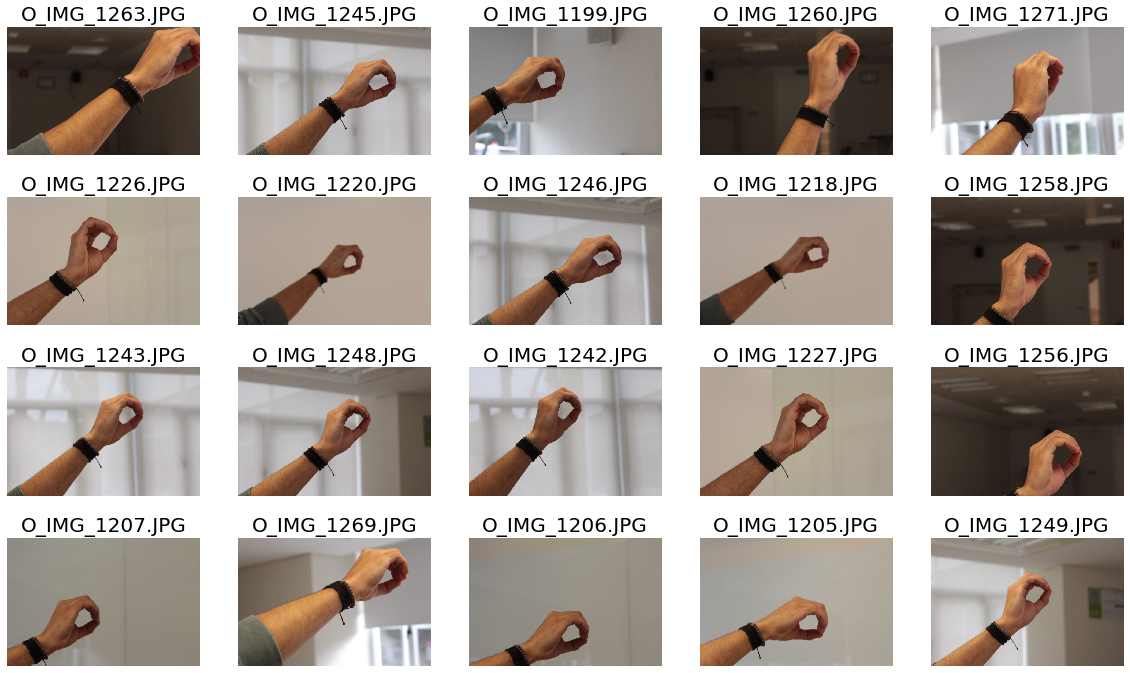

In [5]:
dir_link  = train_dir                            # Link of directory for plotting
dir_label = 'O'                                  # Spesific label for directory
images    = 20                                   # Numbers of images plot
row       = 4                                    # Axes row setting
link      = os.path.join(dir_link, dir_label)    # Full link of images
shape     = {}                                   # Shape of images

fig, ax = plt.subplots(figsize=(20, 12), nrows=row, ncols=images//row)

print(f'Dataset in folder {link}\n')

for i in range(images):
    if images > len(os.listdir(link)):
        print(f"Data in directory is out of number of plot")    
        raise StopExecution
    
    else:
        img_train = plt.imread(os.path.join(link, os.listdir(link)[i]))
        title = dir_label + '_' + os.listdir(link)[i]
        shape[title] = img_train.shape
        
        try:
            ax[i%row,i//row].imshow(img_train)
            ax[i%row,i//row].set_title(title,fontsize=20)
            ax[i%row,i//row].axis('off')
        except:
            pass

print('Shape of Image Data in the folder\n')
shape

In [6]:
# some callbacks for time measurement and early stopping
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.perf_counter()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.perf_counter() - self.epoch_time_start)
        
class LossCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if logs.get("accuracy") >= 0.9:
            print("\nReached 90% accuracy so cancelling training!")
            self.model.stop_training = True

TRAINING_DIR   = train_dir
VALIDATION_DIR = val_dir
#input_shape    = list(shape.values())[0]
input_shape = (224, 224, 3)
num_classes    = len(label)
print(f"input_shape: {input_shape}")

training_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=20,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(
    rescale = 1./255,
)

train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=input_shape[:2],
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=input_shape[:2],
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32
)

input_shape: (224, 224, 3)
Found 1238 images belonging to 24 classes.
Found 348 images belonging to 24 classes.


Inspect a batch in `training_generator`

In [7]:
for i, train_batch in enumerate(train_generator):
    image_batch, label_batch = train_batch
    
    image_batch = tf.constant(image_batch)
    label_batch = tf.constant(label_batch)
    
    if i == 0:
        break

image_batch.shape

TensorShape([32, 224, 224, 3])

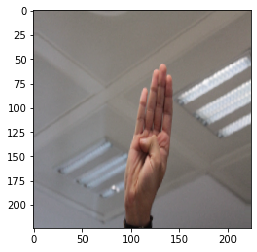

In [8]:
image_batch_ndarray = tf.make_ndarray(tf.make_tensor_proto(image_batch[0]))
plt.imshow(image_batch_ndarray);

In [9]:
label_batch[0]

<tf.Tensor: shape=(24,), dtype=float32, numpy=
array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)>

# Create the base model from the pre-trained neuralnets

We will create the base model from **MobileNet V2** model developed at Google.

In [10]:
# setting layer from transfer model
#local_weights_file = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'  # imagenet

# base_model = tf.keras.applications.inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5(input_shape = input_shape, 
#                          include_top = False, 
#                          weights = None)

local_weights_file = 'mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_160_no_top.h5'  # imagenet

base_model = tf.keras.applications.MobileNetV2(input_shape = input_shape, 
                                              include_top = False, 
                                              weights = None)

base_model.load_weights(local_weights_file)

In [11]:
feature_batch = base_model(image_batch)
feature_batch.shape

TensorShape([32, 7, 7, 1280])

# Feature extraction

## Freeze the convolution base

In [12]:
base_model.trainable = False

In [13]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

## Compile the model

In [14]:
base_learning_rate = 0.00001
time_callback = TimeHistory()
loss_callback = LossCallback()

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Conv2D(32, (5,5), activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 3, 3, 32)          1024032   
_________________________________________________________________
dropout (Dropout)            (None, 3, 3, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 256)               8448      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 24)                6

In [16]:
len(model.trainable_variables)

6

## Train the model

In [17]:
initial_epochs = 100
#validation_steps = 20
steps_per_epoch = train_len // 32   # the number of samples in our dataset divided by the batch size
validation_steps = val_len // 32    # Total number of steps (batches of samples) to draw before stopping 
                                    # when performing validation at the end of every epoch

loss0, accuracy0 = model.evaluate(validation_generator, steps=validation_steps)

10/10 [==============================] - 5s 500ms/step - loss: 3.3601 - accuracy: 0.0250


In [18]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 3.36
initial accuracy: 0.03


In [19]:
history = model.fit(train_generator,
                    epochs=initial_epochs,
                    steps_per_epoch=steps_per_epoch,
                    verbose=1,
                    validation_steps=validation_steps,
                    validation_data=validation_generator,
                    callbacks=[time_callback, loss_callback])

Epoch 1/100
38/38 [==============================] - 39s 1s/step - loss: 3.2929 - accuracy: 0.0381 - val_loss: 3.1370 - val_accuracy: 0.0719
Epoch 2/100
38/38 [==============================] - 40s 1s/step - loss: 3.1343 - accuracy: 0.0789 - val_loss: 3.0822 - val_accuracy: 0.1125
Epoch 3/100
38/38 [==============================] - 41s 1s/step - loss: 3.0774 - accuracy: 0.0829 - val_loss: 3.0226 - val_accuracy: 0.1219
Epoch 4/100
38/38 [==============================] - 40s 1s/step - loss: 3.0367 - accuracy: 0.1036 - val_loss: 2.9524 - val_accuracy: 0.1781
Epoch 5/100
38/38 [==============================] - 40s 1s/step - loss: 3.0040 - accuracy: 0.1227 - val_loss: 2.8682 - val_accuracy: 0.2250
Epoch 6/100
38/38 [==============================] - 40s 1s/step - loss: 2.8797 - accuracy: 0.1534 - val_loss: 2.7347 - val_accuracy: 0.2844
Epoch 7/100
38/38 [==============================] - 40s 1s/step - loss: 2.8132 - accuracy: 0.1915 - val_loss: 2.6087 - val_accuracy: 0.3594
Epoch 8/100
3

Epoch 59/100
38/38 [==============================] - 41s 1s/step - loss: 0.7931 - accuracy: 0.7935 - val_loss: 0.5123 - val_accuracy: 0.9062
Epoch 60/100
38/38 [==============================] - 40s 1s/step - loss: 0.7704 - accuracy: 0.7794 - val_loss: 0.5237 - val_accuracy: 0.9000
Epoch 61/100
38/38 [==============================] - 40s 1s/step - loss: 0.7719 - accuracy: 0.7977 - val_loss: 0.4783 - val_accuracy: 0.9187
Epoch 62/100
38/38 [==============================] - 40s 1s/step - loss: 0.7325 - accuracy: 0.8018 - val_loss: 0.4742 - val_accuracy: 0.9031
Epoch 63/100
38/38 [==============================] - 39s 1s/step - loss: 0.7432 - accuracy: 0.7927 - val_loss: 0.4712 - val_accuracy: 0.9156
Epoch 64/100
38/38 [==============================] - 41s 1s/step - loss: 0.7289 - accuracy: 0.7952 - val_loss: 0.4641 - val_accuracy: 0.9219
Epoch 65/100
38/38 [==============================] - 41s 1s/step - loss: 0.6928 - accuracy: 0.8151 - val_loss: 0.4558 - val_accuracy: 0.9219
Epoch 

In [20]:
print("total time fitting (approx.): {:.2f} s".format(sum(time_callback.times)))

total time fitting (approx.): 4076.36 s


## Learning curves

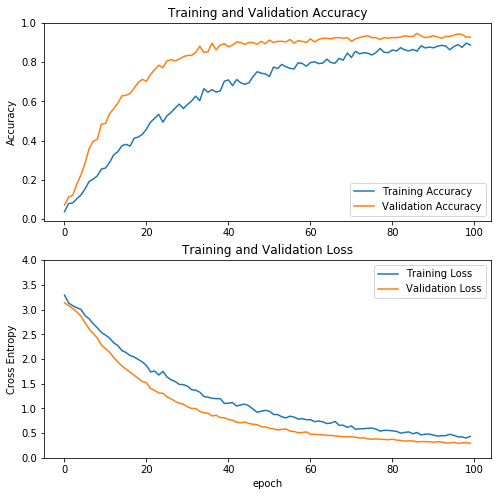

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 4.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [22]:
num_computed_epochs = len(history.epoch)
print(f"number of computed epochs before the fitting stopped: {num_computed_epochs}")

number of computed epochs before the fitting stopped: 100


In [23]:
alphabet = [letter.upper() for letter in "abcdefghiklmnopqrstuvwxy"]

#fn = "./hand-sign-real-data/D-lugo.jpg"

base_test_dir = "dataset/DataSet Signos splitted/test"

test_path_all = [os.path.join(base_test_dir, letter_path, image_path) 
                 for letter_path in os.listdir(base_test_dir)
                    for image_path in os.listdir(os.path.join(base_test_dir, letter_path))]
#print(test_path_all)


print("test three best (the right most is the highest probability)")
percentage = 0.
for i, fn in enumerate(test_path_all):
    #break
    img = keras_prep_image.load_img(fn, target_size=input_shape[:2],
                                    color_mode='rgb')
    x = keras_prep_image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    #print(images.shape)
    classes = model.predict(images)
    classes_name = np.array(alphabet)

    #print(classes)
    
    letter_to_classes = {k: v for k, v in zip(alphabet, classes[0])}
    letter_to_classes = {k: v for k, v in sorted(letter_to_classes.items(), 
                                                 key=lambda item: item[1])}
    #print(letter_to_classes)
    fn_label = os.path.split(os.path.split(fn)[0])[-1]
    predicted_label = list(letter_to_classes.keys())[-3:]
    print(f"{fn} is {predicted_label} ({fn_label in predicted_label})")
    
    #if i == 0:
    #    break
    
    if (fn_label in predicted_label):
        percentage += 1.

test three best (the right most is the highest probability)
dataset/DataSet Signos splitted/test/L/IMG_0988.JPG is ['C', 'I', 'H'] (False)
dataset/DataSet Signos splitted/test/L/IMG_1014.JPG is ['D', 'E', 'N'] (False)
dataset/DataSet Signos splitted/test/L/IMG_1035.JPG is ['C', 'L', 'I'] (True)
dataset/DataSet Signos splitted/test/L/IMG_1015.JPG is ['C', 'D', 'G'] (False)
dataset/DataSet Signos splitted/test/L/IMG_1006.JPG is ['D', 'H', 'G'] (False)
dataset/DataSet Signos splitted/test/L/IMG_1007.JPG is ['L', 'G', 'H'] (True)
dataset/DataSet Signos splitted/test/L/IMG_0999.JPG is ['L', 'H', 'G'] (True)
dataset/DataSet Signos splitted/test/L/IMG_0991.JPG is ['L', 'H', 'G'] (True)
dataset/DataSet Signos splitted/test/R/IMG_1460.JPG is ['S', 'G', 'H'] (False)
dataset/DataSet Signos splitted/test/R/IMG_1495.JPG is ['R', 'H', 'G'] (True)
dataset/DataSet Signos splitted/test/R/IMG_1513.JPG is ['N', 'H', 'G'] (False)
dataset/DataSet Signos splitted/test/R/IMG_1464.JPG is ['E', 'G', 'H'] (Fals

dataset/DataSet Signos splitted/test/A/IMG_9989.JPG is ['L', 'E', 'A'] (True)
dataset/DataSet Signos splitted/test/A/IMG_0021.JPG is ['L', 'H', 'G'] (False)
dataset/DataSet Signos splitted/test/A/IMG_9967.JPG is ['E', 'G', 'A'] (True)
dataset/DataSet Signos splitted/test/A/IMG_9961.JPG is ['R', 'H', 'G'] (False)
dataset/DataSet Signos splitted/test/A/IMG_9999.JPG is ['L', 'G', 'H'] (False)
dataset/DataSet Signos splitted/test/A/IMG_0016.JPG is ['E', 'G', 'H'] (False)
dataset/DataSet Signos splitted/test/M/IMG_1112.JPG is ['G', 'C', 'N'] (False)
dataset/DataSet Signos splitted/test/M/IMG_1056.JPG is ['H', 'G', 'N'] (False)
dataset/DataSet Signos splitted/test/M/IMG_1096.JPG is ['A', 'G', 'D'] (False)
dataset/DataSet Signos splitted/test/M/IMG_1051.JPG is ['H', 'N', 'G'] (False)
dataset/DataSet Signos splitted/test/M/IMG_1062.JPG is ['N', 'G', 'H'] (False)
dataset/DataSet Signos splitted/test/M/IMG_1095.JPG is ['D', 'H', 'G'] (False)
dataset/DataSet Signos splitted/test/M/IMG_1090.JPG is

In [24]:
print(f"percentage of True = {percentage/len(test_path_all):.2f}")

percentage of True = 0.31


# Fine tuning

## Un-freeze the top layers of the model

In [25]:
base_model.trainable = True

In [26]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the 'fine_tune_at' layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  155


## Compile the model

In [27]:
# model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
#               optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
#               metrics=['accuracy'])

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
               metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 3, 3, 32)          1024032   
_________________________________________________________________
dropout (Dropout)            (None, 3, 3, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 256)               8448      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 24)                6

In [29]:
len(model.trainable_variables)

62

## Continue training the model

In [30]:
fine_tune_epochs = num_computed_epochs
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_generator,
                         epochs=total_epochs,
                         steps_per_epoch=steps_per_epoch,
                         initial_epoch=history.epoch[-1],
                         verbose=1,
                         validation_steps=validation_steps,
                         validation_data=validation_generator,
                         callbacks=[time_callback, loss_callback])

Epoch 100/200
38/38 [==============================] - 57s 1s/step - loss: 1.4574 - accuracy: 0.5854 - val_loss: 0.3526 - val_accuracy: 0.9187
Epoch 101/200
38/38 [==============================] - 57s 2s/step - loss: 1.0737 - accuracy: 0.6849 - val_loss: 0.3200 - val_accuracy: 0.9312
Epoch 102/200
38/38 [==============================] - 53s 1s/step - loss: 0.9343 - accuracy: 0.7255 - val_loss: 0.3615 - val_accuracy: 0.9125
Epoch 103/200
38/38 [==============================] - 54s 1s/step - loss: 0.8147 - accuracy: 0.7653 - val_loss: 0.3523 - val_accuracy: 0.9187
Epoch 104/200
38/38 [==============================] - 58s 2s/step - loss: 0.7347 - accuracy: 0.7869 - val_loss: 0.3230 - val_accuracy: 0.9156
Epoch 105/200
38/38 [==============================] - 56s 1s/step - loss: 0.6935 - accuracy: 0.7919 - val_loss: 0.3344 - val_accuracy: 0.9219
Epoch 106/200
38/38 [==============================] - 55s 1s/step - loss: 0.5585 - accuracy: 0.8408 - val_loss: 0.3006 - val_accuracy: 0.9281

In [31]:
print("total time fitting (approx.): {:.2f} s".format(sum(time_callback.times)))

total time fitting (approx.): 801.82 s


In [32]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

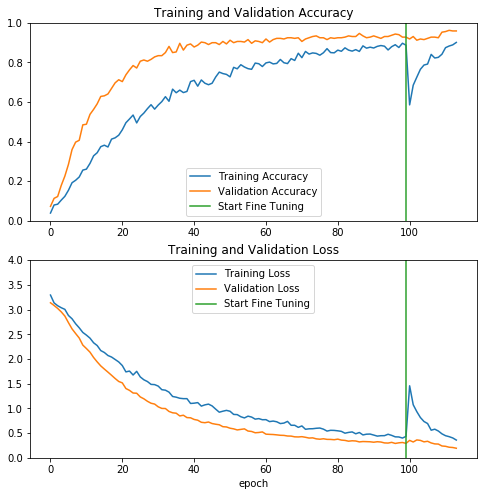

In [33]:
plt.figure(figsize=(8,8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0., 1])
plt.plot([num_computed_epochs-1, num_computed_epochs-1],
         plt.ylim(), label="Start Fine Tuning")
plt.legend(loc="lower center")
plt.title("Training and Validation Accuracy")


plt.subplot(2, 1, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.ylim([0, 4.0])
plt.plot([num_computed_epochs-1, num_computed_epochs-1], 
         plt.ylim(), label="Start Fine Tuning")
plt.legend(loc="upper center")
plt.title("Training and Validation Loss")
plt.xlabel('epoch')
plt.show()

In [ ]:
alphabet = [letter.upper() for letter in "abcdefghiklmnopqrstuvwxy"]

#fn = "./hand-sign-real-data/D-lugo.jpg"

base_test_dir = "dataset/DataSet Signos splitted/test"

test_path_all = [os.path.join(base_test_dir, letter_path, image_path) 
                 for letter_path in os.listdir(base_test_dir)
                    for image_path in os.listdir(os.path.join(base_test_dir, letter_path))]
#print(test_path_all)


print("test three best (the right most is the highest probability)")
percentage = 0.
for i, fn in enumerate(test_path_all):
    #break
    img = keras_prep_image.load_img(fn, target_size=input_shape[:2],
                                    color_mode='rgb')
    x = keras_prep_image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    #print(images.shape)
    classes = model.predict(images)
    classes_name = np.array(alphabet)

    #print(classes)
    
    letter_to_classes = {k: v for k, v in zip(alphabet, classes[0])}
    letter_to_classes = {k: v for k, v in sorted(letter_to_classes.items(), 
                                                 key=lambda item: item[1])}
    #print(letter_to_classes)
    fn_label = os.path.split(os.path.split(fn)[0])[-1]
    predicted_label = list(letter_to_classes.keys())[-3:]
    print(f"{fn} is {predicted_label} ({fn_label in predicted_label})")
    
    #if i == 0:
    #    break
    
    if (fn_label in predicted_label):
        percentage += 1.

test three best (the right most is the highest probability)
dataset/DataSet Signos splitted/test/L/IMG_0988.JPG is ['D', 'H', 'I'] (False)
dataset/DataSet Signos splitted/test/L/IMG_1014.JPG is ['D', 'N', 'O'] (False)
dataset/DataSet Signos splitted/test/L/IMG_1035.JPG is ['L', 'K', 'I'] (True)
dataset/DataSet Signos splitted/test/L/IMG_1015.JPG is ['H', 'I', 'D'] (False)
dataset/DataSet Signos splitted/test/L/IMG_1006.JPG is ['D', 'G', 'H'] (False)
dataset/DataSet Signos splitted/test/L/IMG_1007.JPG is ['S', 'G', 'H'] (False)
dataset/DataSet Signos splitted/test/L/IMG_0999.JPG is ['U', 'H', 'I'] (False)
dataset/DataSet Signos splitted/test/L/IMG_0991.JPG is ['G', 'I', 'H'] (False)
dataset/DataSet Signos splitted/test/R/IMG_1460.JPG is ['I', 'G', 'H'] (False)
dataset/DataSet Signos splitted/test/R/IMG_1495.JPG is ['D', 'G', 'H'] (False)
dataset/DataSet Signos splitted/test/R/IMG_1513.JPG is ['I', 'H', 'G'] (False)
dataset/DataSet Signos splitted/test/R/IMG_1464.JPG is ['G', 'H', 'I'] (

dataset/DataSet Signos splitted/test/A/IMG_9989.JPG is ['A', 'G', 'H'] (True)
dataset/DataSet Signos splitted/test/A/IMG_0021.JPG is ['G', 'H', 'D'] (False)
dataset/DataSet Signos splitted/test/A/IMG_9967.JPG is ['A', 'G', 'H'] (True)
dataset/DataSet Signos splitted/test/A/IMG_9961.JPG is ['R', 'G', 'H'] (False)
dataset/DataSet Signos splitted/test/A/IMG_9999.JPG is ['D', 'I', 'H'] (False)
dataset/DataSet Signos splitted/test/A/IMG_0016.JPG is ['D', 'S', 'H'] (False)
dataset/DataSet Signos splitted/test/M/IMG_1112.JPG is ['S', 'I', 'H'] (False)
dataset/DataSet Signos splitted/test/M/IMG_1056.JPG is ['G', 'I', 'H'] (False)
dataset/DataSet Signos splitted/test/M/IMG_1096.JPG is ['D', 'H', 'G'] (False)
dataset/DataSet Signos splitted/test/M/IMG_1051.JPG is ['D', 'H', 'G'] (False)
dataset/DataSet Signos splitted/test/M/IMG_1062.JPG is ['I', 'S', 'H'] (False)
dataset/DataSet Signos splitted/test/M/IMG_1095.JPG is ['G', 'S', 'M'] (True)
dataset/DataSet Signos splitted/test/M/IMG_1090.JPG is 

In [ ]:
print(f"percentage of True = {percentage/len(test_path_all):.2f}")

# Pre-trained model conversion

## Convert the model

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

## Save the TF Lite model

In [ ]:
with tf.io.gfile.GFile('classif_preTrained.tflite', 'wb') as f:
    f.write(tflite_model)

## Load TFLite model and allocate tensors

In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

## Get input and output tensors

In [ ]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

## Test the TensorFlow Lite model on random input data

In [ ]:
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

The function `get_tensor()` returns a copy of the tensor data.  
Use `tensor()` in order to get a pointer to the tensor.

In [ ]:
tflite_results = interpreter.get_tensor(output_details[0]['index'])

## Test the TensorFlow model on random input data

In [ ]:
tf_results = model(tf.constant(input_data))

## Compare the result.

In [ ]:
for tf_result, tflite_result in zip(tf_results, tflite_results):
    np.testing.assert_almost_equal(tf_result, tflite_result, decimal=5)